In [804]:
# debugging mode
Debug = False

In [805]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [806]:
print("Survival rate :", round(len(df[df['Survived'] == 1]) / len(df), 2))

Survival rate : 0.38


<AxesSubplot:title={'center':'Female'}, ylabel='Frequency'>

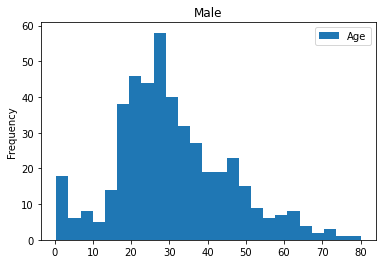

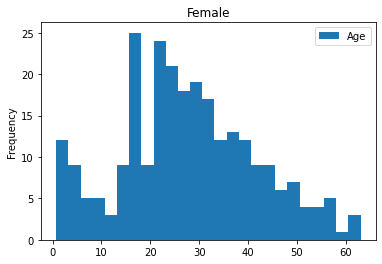

In [807]:
af = df[['Age', 'Sex']]
male = af[af['Sex'] == 'male']
female = af[af['Sex'] == 'female']
male.plot(kind='hist', bins = 25, title="Male")
female.plot(kind='hist', bins = 25, title="Female")

<AxesSubplot:xlabel='Survived', ylabel='Sex'>

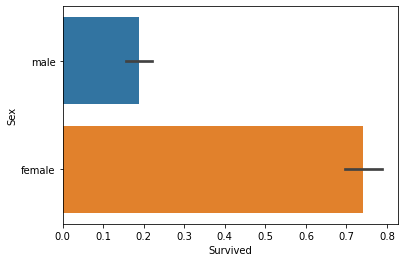

In [808]:
sns.barplot(y="Sex", x="Survived", data=df)

<AxesSubplot:xlabel='Survived', ylabel='Age'>

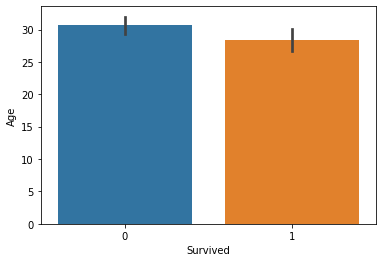

In [809]:
sns.barplot(y="Age", x="Survived", data=df)

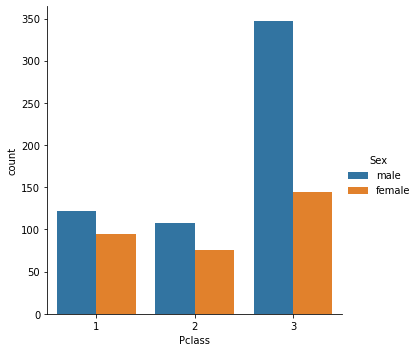

In [810]:
sns.catplot(x="Pclass", hue="Sex", data=df, kind='count')

In [811]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [812]:

import numpy as np
from sklearn import metrics

def compute_auroc(truth, prediction):
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
    return metrics.auc(fpr, tpr)


def plot_auroc(truth, predictions):
    fpr, tpr, threshold = metrics.roc_curve(truth, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

def apply_model(model, features, validation_function=compute_auroc, print_to_screen=True, show_auroc=False):
    pred_tree_train = model.predict_proba(df_train[features])
    pred_tree_test = model.predict_proba(df_test[features])

    pred_churn_tree_train = pd.Series(map(lambda x: x[1], pred_tree_train))
    pred_churn_tree_test = pd.Series(map(lambda x: x[1], pred_tree_test))

    validation_result_train = validation_function(
        df_train['Survived'], pred_churn_tree_train)
    validation_result_test = validation_function(
        df_test['Survived'], pred_churn_tree_test)

    if(print_to_screen):
        print("Result on trainset:")
        print(validation_result_train)
        print()
        print("Result on testset:")
        print(validation_result_test)
    if(show_auroc):
        plot_auroc(df_test['Survived'], pred_churn_tree_test)

    return (validation_result_train, validation_result_test)
    
def convert_sex(Sex):
    if Sex == 'male':
        return 1
    else:
        return 0


(623, 13) (268, 13)
0.38362760834670945
0.3843283582089552


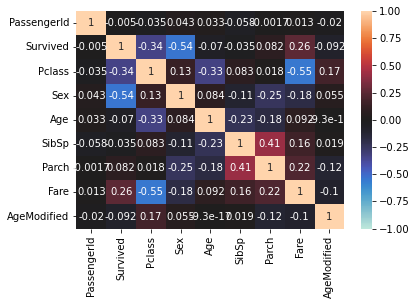

In [813]:
#Prepping dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

if not Debug:
    df = shuffle(df) 


df['Sex'] = df['Sex'].apply(convert_sex)


df['AgeModified'] = np.where(df['Age'].isna(), 1, 0)
df['Age'].fillna((df['Age'].mean()), inplace=True)

sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)




df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['Survived'], random_state=17)
print(df_train.shape, df_test.shape)
print(df_train['Survived'].mean())
print(df_test['Survived'].mean())


#remove missing vars from training set
#df_train = df_train.dropna(subset=['Age'])



In [814]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)

featuresModel1 = ['Age', 'Sex', 'Pclass', 'Fare']

dt.fit(df_train[featuresModel1], df_train['Survived'])


DecisionTreeClassifier(max_depth=3)

Result on trainset:
0.8716821391213389

Result on testset:
0.8261253309796999


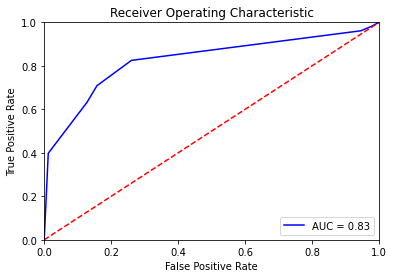

(0.8716821391213389, 0.8261253309796999)

In [815]:
apply_model(dt, featuresModel1, show_auroc=True)

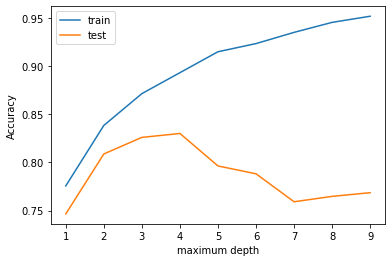

In [816]:
err_train = []
err_test = []
depths = range(1, 10)

for depth in depths:
    dt2 = DecisionTreeClassifier(max_depth=depth)
    dt2.fit(df_train[featuresModel1], df_train['Survived'])
    err_train_i, err_test_i = apply_model(
        dt2, featuresModel1, print_to_screen=False)
    err_train.append(err_train_i)
    err_test.append(err_test_i)

plt.plot(depths, err_train, label='train')
plt.plot(depths, err_test, label='test')
plt.legend()
plt.xlabel('maximum depth')
plt.ylabel('Accuracy')
plt.show()


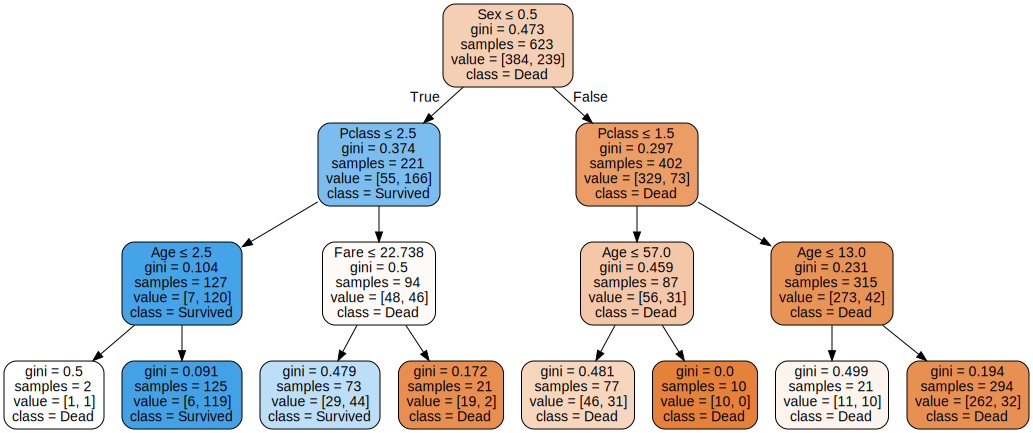

In [817]:
from sklearn import tree
import graphviz


def plot_tree(model, features):
    # Generate plot data
    dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names=features,
                                    class_names=['Dead', 'Survived'],
                                    filled=True, rounded=True,
                                    special_characters=True)

    # Turn into graph using graphviz
    graph = graphviz.Source(dot_data)

    # Write out a pdf
    graph.render("decision_tree")

    # Display in the notebook
    return graph


plot_tree(dt, featuresModel1)

Result on trainset:
0.9478240498605299

Result on testset:
0.808237716975581


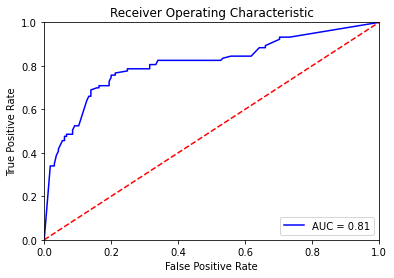

(0.9478240498605299, 0.808237716975581)

In [818]:
#random forest 
from sklearn.ensemble import RandomForestClassifier

featuresModelRF = ['Age', 'Sex', 'Pclass'] 
#featuresModelRF = ['Age', 'Sex', 'Pclass', 'Fare'] 
forest = RandomForestClassifier(n_estimators=25, random_state = 67)
forest.fit(df_train[featuresModelRF], df_train['Survived'])

apply_model(forest, featuresModelRF, show_auroc=True)

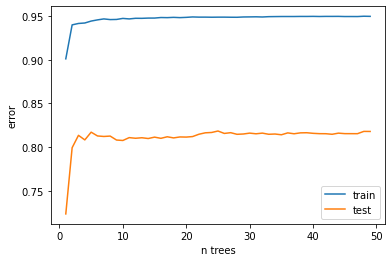

In [819]:
# error visualisation
err_train = []
err_test = []
n_trees = range(1, 50)

for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree, random_state = 123)
    rf.fit(df_train[featuresModelRF], df_train['Survived'])
    err_train_i, err_test_i = apply_model(rf, featuresModelRF, print_to_screen=False)
    err_train.append(err_train_i)
    err_test.append(err_test_i)
    
plt.plot(n_trees, err_train, label='train')
plt.plot(n_trees, err_test, label='test')
plt.legend()
plt.xlabel('n trees')
plt.ylabel('error')
plt.show()

In [820]:
#prep
dftest = pd.read_csv('test.csv')

dftest['Sex'] = dftest['Sex'].apply(convert_sex)


dftest['AgeModified'] = np.where(dftest['Age'].isna(), 1, 0)
dftest['Age'].fillna((dftest['Age'].mean()), inplace=True)
dftest['Fare'].fillna((dftest['Fare'].mean()), inplace=True)



#results

results_forest = pd.DataFrame([], columns=['PassengerId','Survived'])
results_standard = pd.DataFrame([], columns=['PassengerId','Survived'])
results_forest['PassengerId'] = dftest['PassengerId']
results_standard['PassengerId'] = dftest['PassengerId']
results_forest['Survived'] = forest.predict(dftest[['Age', 'Sex', 'Pclass']])
results_standard['Survived'] = dt.predict(dftest[['Age', 'Sex', 'Pclass', 'Fare']])


results_standard.to_csv('results_standard.csv', index=False)
results_forest.to_csv('results_forest.csv', index=False)

